0. Upload .parquet files with labels\
    0.1 Do EDA
1. Filter .parquet files used BEFORE downloading
2. Filter already downloaded images (MAYBE NO)

In [160]:
import os
import pandas as pd
from datasets import load_dataset
import numpy as np

from tqdm import tqdm
tqdm.pandas()

from time import time

In [3]:
IMAGE_RESOLUTION = 256

# Upload .parquet files with labels

In [196]:
# temporary
folder = f'/mnt/disks/disk-big2/laion200m-od-labels-1shard'

od_labels_files = os.listdir(folder)
od_labels_files = [os.path.join(folder, file) for file in od_labels_files]
processed_urls = load_dataset("parquet", data_files={"train": od_labels_files}, split="train")

Resolving data files:   0%|          | 0/61 [00:00<?, ?it/s]

In [197]:
processed_urls

Dataset({
    features: ['url', 'label', 'score', 'top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y'],
    num_rows: 8624
})

# EDA

## test HF vs pandas speed

In [198]:
IMAGE_RESOLUTION = 256
BOX_SIZE_THRESHOLD = 100

In [200]:
t = time()
df = processed_urls.to_pandas()
df['box_size'] = df.progress_apply(lambda x: (x.bottom_right_y - x.top_left_y)*(x.bottom_right_x - x.top_left_x),
                                   axis=1)
df['box_perc'] = df.progress_apply(lambda x: int(100 * x.box_size / (IMAGE_RESOLUTION*IMAGE_RESOLUTION)),
                                   axis=1)
df_invalid = df[(df['label']=='person') & (df['box_size'] > BOX_SIZE_THRESHOLD)]
list_invalid_urls = list(df_invalid['url'].unique())

time() - t

100%|██████████| 8624/8624 [00:00<00:00, 59805.89it/s]


0.5082385540008545

In [199]:
t = time()
def get_box_size(example):
        example['box_size'] = (example['bottom_right_y'] - example['top_left_y']) * \
            (example['bottom_right_x'] - example['top_left_x'])
        example['box_perc'] = int(100 * example['box_size'] / (IMAGE_RESOLUTION*IMAGE_RESOLUTION))
        
        return example

processed_urls = processed_urls.map(get_box_size)
processed_urls_invalid = processed_urls.filter(lambda example: example['label'] == 'person' and example['box_size'] > BOX_SIZE_THRESHOLD)
list_invalid_urls = list(np.unique((processed_urls_invalid['url'])))

time() - t

0.07403826713562012

--------

In [97]:
df = processed_urls.to_pandas()

In [116]:
# 17 692 257
# len(df[df['url'].duplicated(keep=False)].sort_values(by=['url']))

In [101]:
len(df['url'].unique())

11748293

In [100]:
len(df[df['url'].isna()])

0

In [102]:
len(df[df['label']=='person']['url'].unique())

5520405

In [103]:
100 * len(df[df['label']=='person']['url'].unique()) / len(df['url'].unique())

46.98899661423153

In [104]:
df['box_size'] = df.progress_apply(lambda x: (x.bottom_right_y - x.top_left_y)*(x.bottom_right_x - x.top_left_x),
                                   axis=1)

100%|██████████| 24238088/24238088 [15:19<00:00, 26357.19it/s]


In [105]:
IMAGE_RESOLUTION*IMAGE_RESOLUTION

65536

In [106]:
df['box_perc'] = df.progress_apply(lambda x: int(100 * x.box_size / (IMAGE_RESOLUTION*IMAGE_RESOLUTION)),
                                   axis=1)

100%|██████████| 24238088/24238088 [06:13<00:00, 64911.96it/s] 


In [107]:
df_people = df[df['label']=='person']

In [108]:
df_people['box_size'].min(), df_people['box_size'].max()

(12.1875, 65584.0078125)

<Axes: >

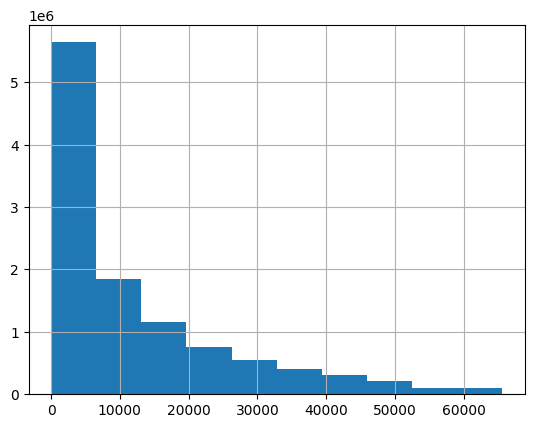

In [109]:
df_people['box_size'].hist()

<Axes: >

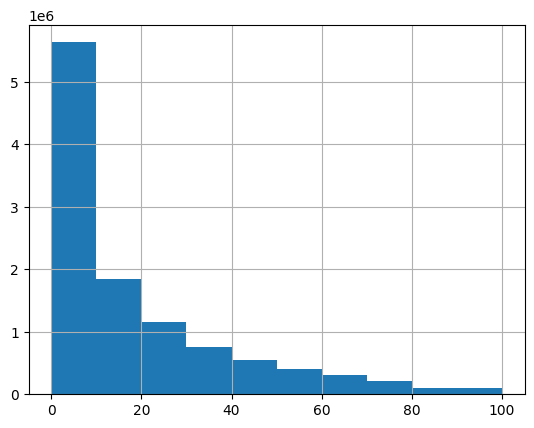

In [110]:
df_people['box_perc'].hist()

In [156]:
BOX_SIZE_THRESHOLD = 1000

In [157]:
df_people_invalid = df_people[df_people['box_size'] > BOX_SIZE_THRESHOLD]

In [158]:
people_invalid_urls = df_people_invalid['url'].unique()

In [153]:
df_people_valid = df_people[(df_people['box_size'] <= BOX_SIZE_THRESHOLD) & 
                            (~df_people['url'].isin(people_invalid_urls))]
len(df_people_valid['url'].unique())

344431

In [119]:
100 * len(df_people_valid['url'].unique()) / len(df_people['url'].unique())

0.21020196887728346

In [154]:
100 * len(df_people_valid['url'].unique()) / len(df['url'].unique())

2.9317535747533707

In [159]:
100 * len(df_people_invalid['url'].unique()) / len(df['url'].unique())

44.05724303947816

In [155]:
2.9 * 125000000 / 100

3625000.0

## test box_size/box_perc thresholds

In [142]:
threshold_min = 100
threshold_max = 1000

In [143]:
people_invalid_urls_test = df_people[df_people['box_size'] > threshold_max]['url'].unique()

In [144]:
df_people_test = df_people[(df_people['box_size'] > threshold_min) & (df_people['box_size'] <= threshold_max) & 
                           (~df_people['url'].isin(people_invalid_urls_test))]

In [137]:
# df_people_test[df_people_test['url']=='https://images.squarespace-cdn.com/content/v1/55b987c0e4b0b0462f3ebc28/1517379216235-EU64OF2U7E6GFFVCM87S/ke17ZwdGBToddI8pDm48kI2pdK8ohqNq39lQ8aNodSp7gQa3H78H3Y0txjaiv_0fDoOvxcdMmMKkDsyUqMSsMWxHk725yiiHCCLfrh8O1z5QPOohDIaIeljMHgDF5CVlOqpeNLcJ80NK65_fV7S1Ua00Q67jLYoe2jJwEeE3iV3qK_K0mXONrX-QDVHRyV2WchU0LD5eNWUVd3tZidBHnQ/07_RimuReclaimed100mmx15mmPlanks.jpg']

In [149]:
df_people_test['url'].sample(n=1).iloc[0]

'https://i.pinimg.com/236x/a8/84/84/a88484f00dffcb4d7c26dfa737424174--camels.jpg'

In [29]:
len(df['url'].unique())

3673257

In [28]:
len(df_people_invalid['url'].unique())

1722789

In [33]:
100 * len(df_people_invalid['url'].unique()) / len(df['url'].unique())

46.90085665119538

In [35]:
people_invalid_urls = df_people_invalid['url'].unique()

In [37]:
people_invalid_urls[10]

'http://st.depositphotos.com/1011643/4923/i/170/depositphotos_49236657-Happy-woman-with-her-horse.jpg'

# Filter .parquet files used BEFORE downloading

In [161]:
t = time()
input_files = ['/shared_drive/user-files/laion_dataset_200M/laion200m-train-12_2M-subset.parquet'] 
input_dataset = load_dataset("parquet", data_files={"train": input_files}, split="train")
df_input_dataset = input_dataset.to_pandas()

time() - t

26.957192420959473

In [162]:
t = time()
df_input_dataset = pd.read_parquet('/shared_drive/user-files/laion_dataset_200M/laion200m-train-12_2M-subset.parquet')

time() - t

43.24901485443115